In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'

import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_cell_metrics'
misc.get_or_create_subdir(figdir)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)

'/mnt/home/szheng/ceph/place_variability/data/paper'

In [3]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

In [4]:
%%time
all_fields_recombined_all = {}
pf_params_recombined_all = {}
fr_map_trial_df_all = {}
fr_map_all = {}
occu_map_all = {}
pval_all = {}
best_n_all = {}
X_pwc_all = {}
X_raw_all = {}
changes_df_all = {}
var_res_all = {}
corr_all = {}
all_sw_d_all = {}
all_sw_with_metrics_d_all = {}
trial_index_to_index_within_df_all = {}

spk_beh_df_all = {}

for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    
    res=dpp.load_spk_beh_df(data_dir_full,load_only=True)
    if res is not None:
        spk_beh_df = res['spk_beh_df']
        spk_beh_df,_ = dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
        spk_beh_df_all[ani,sess] = spk_beh_df
        trial_index_to_index_within_df = dpp.trial_index_to_index_within_trialtype(spk_beh_df)
        trial_index_to_index_within_df_all[ani,sess] = trial_index_to_index_within_df
        

    pf_res_recombine = pfrc.main(data_dir_full,force_reload=False,load_only=True)

    all_fields_recombined=pf_res_recombine['all_fields_recombined']
    all_fields_recombined_all[ani,sess] = all_fields_recombined
    pf_params_recombined = pf_res_recombine['params_recombined']
    pf_params_recombined_all[ani,sess] = pf_params_recombined

    fr_map_all = fmos.main(data_dir_full,force_reload=False,load_only=True)
    fr_map_trial_df = fr_map_all['fr_map_trial_df']
    fr_map_trial_df_all[ani,sess] = fr_map_trial_df
    fr_map = fr_map_all['fr_map']
    fr_map_all[ani,sess] = fr_map
    occu_map = fr_map_all['occu_map']
    occu_map_all[ani,sess] = occu_map



    sw_res = sdos.main(data_dir_full,force_reload=False,load_only=True)
    pval = sw_res['pval']
    pval_all[ani,sess]=pval
    best_n = sw_res['best_n']
    best_n_all[ani,sess] = best_n
    X_pwc = sw_res['X_pwc']
    X_pwc_all[ani,sess] = X_pwc
    X_raw = sw_res['X_raw']
    X_raw_all[ani,sess]=X_raw
    changes_df = sw_res['changes_df']
    changes_df_all[ani,sess] = changes_df
    var_res = sw_res['var_res']
    var_res_all[ani,sess]=var_res
    corr = sw_res['corr']
    corr_all[ani,sess] = corr

    sw_info_res=gasam.main(data_dir_full,force_reload=False,load_only=True)
    if sw_info_res is None:
        sw_info_res=gasam.main(data_dir_full,force_reload=True,load_only=False)
    all_sw_d = sw_info_res['all_sw_d']
    all_sw_d_all[ani,sess] = all_sw_d
    all_sw_with_metrics_d = sw_info_res['all_sw_with_metrics_d']
    all_sw_with_metrics_d_all[ani,sess] = all_sw_with_metrics_d

all_fields_recombined_all = pd.concat(all_fields_recombined_all,axis=0)
pf_params_recombined_all = pd.concat(pf_params_recombined_all,axis=0)
fr_map_trial_df_all = pd.concat(fr_map_trial_df_all,axis=0)
occu_map_all = pd.concat(occu_map_all,axis=0)
fr_map_all = pd.concat(fr_map_all,axis=0)

pval_all = pd.concat(pval_all,axis=0)
X_pwc_all = pd.concat(X_pwc_all,axis=0)
X_raw_all = pd.concat(X_raw_all,axis=0)
changes_df_all = pd.concat(changes_df_all,axis=0)
var_res_all = pd.concat(var_res_all,axis=0)
corr_all = pd.concat(corr_all,axis=0)
all_sw_d_all = pd.concat(all_sw_d_all,axis=0)
all_sw_with_metrics_d_all = pd.concat(all_sw_with_metrics_d_all,axis=0)
best_n_all = pd.concat(best_n_all,axis=0)

spk_beh_df_all = pd.concat(spk_beh_df_all,axis=0)




/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_sw_info_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_d

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/switch_analysis/all_sw_info_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210312/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210312/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210312/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210312/py_data/switch_analysis/all_sw_info_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_d

/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201208/py_data/switch_analysis/all_sw_info_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201206/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201206/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201206/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201206/py_data/switch_analysis/all_sw_info_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/

In [32]:
### save all the preprocessed stuff!!!
import pickle
prepped_data_agg = {
    'all_fields_recombined_all':all_fields_recombined_all,
    'pf_params_recombined_all':pf_params_recombined_all,
    'fr_map_trial_df_all':fr_map_trial_df_all,
    'fr_map_all':fr_map_all,
    'occu_map_all':occu_map_all,
    'pval_all':pval_all,
    'X_pwc_all':X_pwc_all,
    'X_raw_all':X_raw_all,
    'changes_df_all':changes_df_all,
    'var_res_all':var_res_all,
    'corr_all':corr_all,
    'all_sw_d_all':all_sw_d_all,
    'all_sw_with_metrics_d_all':all_sw_with_metrics_d_all,
    'best_n_all':best_n_all,
    'spk_beh_df_all':spk_beh_df_all,
}
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
pickle.dump(prepped_data_agg,open(fn_full,'wb'))

In [4]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']

pval_all = prepped_data_agg['pval_all']
# X_pwc_all = prepped_data_agg['X_pwc_all']
# X_raw_all = prepped_data_agg['X_raw_all']
# changes_df_all = prepped_data_agg['changes_df_all']
var_res_all = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
# all_sw_d_all = prepped_data_agg['all_sw_d_all']
# all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all = prepped_data_agg['best_n_all']
# spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 


In [5]:
import glob
cell_metrics_df_all = {}
for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    
    cell_metrics=glob.glob(os.path.join(data_dir_full,'*cell_metrics.cellinfo.mat'))[0]
    cell_metrics = dpn.loadmat_full(cell_metrics,'cell_metrics')
    
    metrics=['UID','putativeCellType','firingRate','firingRateCV','firingRate_NREMstate','firingRate_REMstate','firingRate_WAKEstate','burstIndex_Mizuseki2012']
    cell_metrics_df = pd.DataFrame({k:cell_metrics[k] for k in metrics})
    cell_metrics_df_all[ani,sess] = cell_metrics_df
cell_metrics_df_all = pd.concat(cell_metrics_df_all,axis=0)

cell_metrics_df_all['UID'] = cell_metrics_df_all['UID'].astype(int)
cell_metrics_df_all = cell_metrics_df_all.reset_index(level=2,drop=True).set_index('UID',append=True)

In [5]:
### save cell_metrics_df_all!!!!
fn = 'cell_metrics_df_all.p'
fn_full = os.path.join(data_dir,fn)
# cell_metrics_df_all.to_pickle(fn_full)
cell_metrics_df_all = pickle.load(open(fn_full,'rb'))

In [9]:
# field with any switch vs no switch, metrics
task_index=0
cell_with_any_sw_one_task = best_n_all.loc[(slice(None),slice(None),task_index)].groupby(level=(0,1,3)).apply(lambda x:(x>0).any())
cell_metrics_df_all['has_switch']  = cell_with_any_sw_one_task

ma=cell_metrics_df_all['has_switch'].notna()
cell_metrics_df_all_pc = cell_metrics_df_all.loc[ma]

In [43]:
cell_metrics_df_all_pc

putativeCellType  firingRate  firingRateCV  \
                         UID                                              
e13_26m1 e13_26m1_210913 3     Pyramidal Cell    0.043923      0.848081   
                         27    Pyramidal Cell    9.412340      0.391419   
                         29    Pyramidal Cell    2.406657      0.643068   
                         30    Pyramidal Cell    2.335488      0.544310   
                         31    Pyramidal Cell    2.276269      0.873728   
...                                       ...         ...           ...   
e14_2m3  e14_2m3_201118  46    Pyramidal Cell    1.365643      0.420370   
                         47    Pyramidal Cell    1.695707      0.520709   
                         48    Pyramidal Cell    9.430529      0.230468   
                         50    Pyramidal Cell    0.744755      0.488689   
                         53    Pyramidal Cell    2.381342      0.620151   

                              firingRate_NREMstate  firingRate_REMstate  \
                         UID                                              
e13_26m1 e13_26m1_210913 3                0.059936             0.050847   
                         27               5.158457            15.974576   
                         29               1.581516             0.779661   
                         30               1.856489             0.855932   
                         31               2.357023             0.898305   
...                                            ...                  ...   
e14_2m3  e14_2m3_201118  46               1.615082             2.296433   
                         47               1.873600             2.394834   
                         48               9.483798             9.209102   
                         50               0.802001             0.639606   
                         53               2.029545             2.211562   

                              firingRate_WAKEstate  burstIndex_Mizuseki2012  \
                         UID                                                  
e13_26m1 e13_26m1_210913 3                0.032201                 0.125523   
                         27              12.255754                 0.113205   
                         29               3.003303                 0.411306   
                         30               2.686655                 0.195299   
                         31               2.234699                 0.313593   
...                                            ...                      ...   
e14_2m3  e14_2m3_201118  46               1.012281                 0.076169   
                         47               1.440392                 0.125047   
                         48               9.407146                 0.351201   
                         50               0.698052                 0.081596   
                         53               2.772981                 0.133637   

                             has_switch  
                         UID             
e13_26m1 e13_26m1_210913 3         True  
                         27       False  
                         29        True  
                         30       False  
                         31        True  
...                                 ...  
e14_2m3  e14_2m3_201118  46        True  
                         47       False  
                         48       False  
                         50        True  
                         53       False  

[4486 rows x 8 columns]

[None]

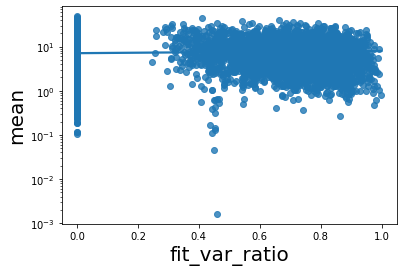

In [18]:
ax=sns.regplot(data=var_res_all,x='fit_var_ratio',y='mean')
ax.set(yscale='log')


In [29]:



cell_metrics_df_all_pc['exp_var_ratio']=\
var_res_all['fit_var_ratio'].groupby(level=(0,1,2,4)).mean().loc[(slice(None),slice(None),0)]

/tmp/ipykernel_2185678/3124063319.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_metrics_df_all_pc['exp_var_ratio']=\


In [36]:
exp_var_ratio.loc['e13_26m1','e13_26m1_210913',0,slice(None),31]

0.0  0    0.541283
1.0  0    0.000000
Name: exp_var_ratio, dtype: float64

In [19]:
# get 
best_n_if_change=pval_all.loc[:,(slice(None),'pval')].droplevel(1,axis=1).idxmin(axis=1)
inds=pd.MultiIndex.from_frame(best_n_if_change.reset_index())
pval_all_best=pval_all.stack(level=0).loc[inds].droplevel(-1)

exp_var_ratio = copy.copy(pval_all_best['exp_var_ratio'])
inds=best_n_all.index[best_n_all==0].intersection(exp_var_ratio.index)
exp_var_ratio.loc[inds]=0
best_n_exp_var_ratio_mean=exp_var_ratio.groupby(level=(0,1,2,4)).mean().loc[(slice(None),slice(None),0)]



cell_metrics_df_all_pc['best_n_exp_var_ratio_mean']=best_n_exp_var_ratio_mean


/tmp/ipykernel_2185678/502185419.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_metrics_df_all_pc['best_n_exp_var_ratio_mean']=best_n_exp_var_ratio_mean


In [27]:
pd.concat([np.log(cell_metrics_df_all_pc['firingRate']),cell_metrics_df_all_pc[x]],axis=1).rcorr()

,firingRate,best_n_exp_var_ratio_mean
firingRate,-,
best_n_exp_var_ratio_mean,0.003,-


In [31]:
cell_metrics_df_all_pc[x]

                           UID
e13_26m1  e13_26m1_210913  3      5.539440e-01
                           27     1.862666e-31
                           29     1.248944e-01
                           30     7.381257e-32
                           31     2.706414e-01
                                      ...     
e14_2m3   e14_2m3_201118   46     1.999770e-01
                           47     0.000000e+00
                           48     3.693098e-31
                           50     2.534903e-01
                           53     9.956939e-33
Name: exp_var_ratio, Length: 4486, dtype: float64

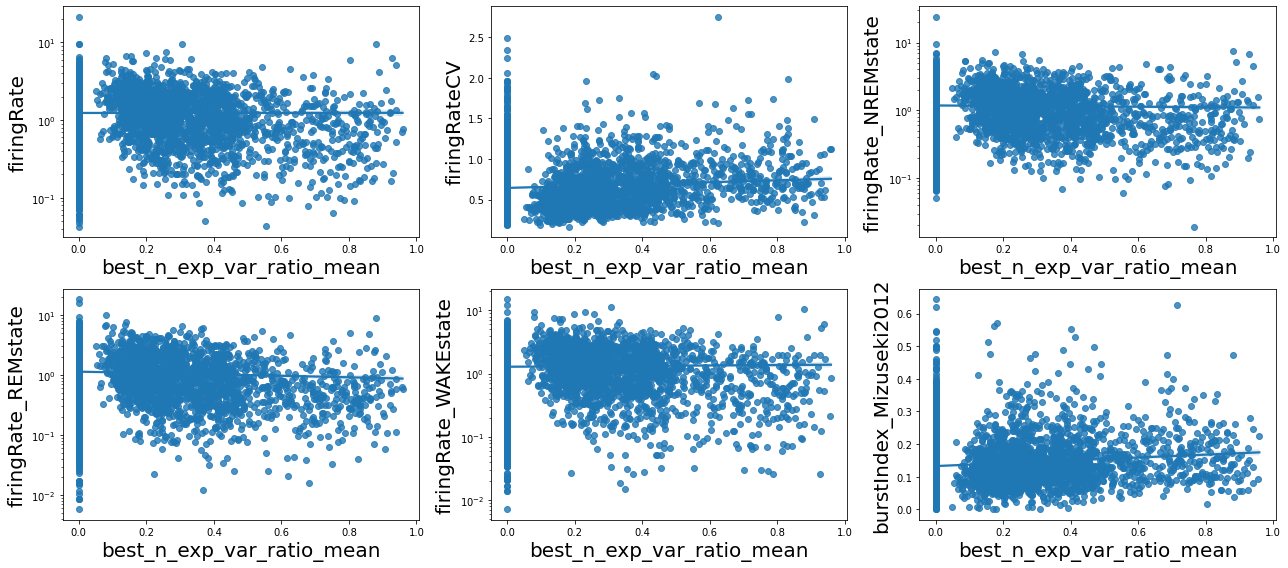

In [25]:
# plot
metrics=['UID','putativeCellType','firingRate','firingRateCV','firingRate_NREMstate','firingRate_REMstate','firingRate_WAKEstate','burstIndex_Mizuseki2012']
nplots = len(metrics)-2
x='best_n_exp_var_ratio_mean'
fig,axs=ph.subplots_wrapper(nplots)
metrics_sub=[m for m in metrics if m not in ['UID','putativeCellType']]
for ii,m in enumerate(metrics_sub):
    ax=axs.ravel()[ii]
    ax=sns.regplot(ax=ax,x=x,y=m,data=cell_metrics_df_all_pc)
    if 'firingRate' in m and 'CV' not in m:
        ax.set_yscale('log')
plt.tight_layout()

In [10]:
import switch_and_cell_metrics as sacm

In [59]:
X_pwc_all

0          1          2   \
e13_26m1 e13_26m1_210913 0 0.0  3  0        NaN   1.389282        NaN   
                                27 0        NaN  33.067719        NaN   
                                29 0        NaN  10.396074        NaN   
                                   1        NaN  26.288630        NaN   
                                   2        NaN  17.481232        NaN   
...                                         ...        ...        ...   
e14_2m3  e14_2m3_201118  0 both 30 0   8.682727   8.682727   8.682727   
                                32 0  11.835044  11.835044  11.835044   
                                38 0   9.374712   9.374712   9.374712   
                                47 0   6.453665   6.453665   6.453665   
                                53 0   3.517027   3.517027   3.517027   

                                             3          4          5   \
e13_26m1 e13_26m1_210913 0 0.0  3  0   1.389282        NaN        NaN   
                                27 0  33.067719        NaN        NaN   
                                29 0  10.396074        NaN        NaN   
                                   1  26.288630        NaN        NaN   
                                   2  17.481232        NaN        NaN   
...                                         ...        ...        ...   
e14_2m3  e14_2m3_201118  0 both 30 0   8.682727   8.682727   8.682727   
                                32 0  11.835044  11.835044  11.835044   
                                38 0   9.374712   9.374712   9.374712   
                                47 0   6.453665   6.453665   6.453665   
                                53 0   3.517027   3.517027   3.517027   

                                             6          7          8   \
e13_26m1 e13_26m1_210913 0 0.0  3  0   1.389282        NaN   1.389282   
                                27 0  33.067719        NaN  33.067719   
                                29 0  10.396074        NaN  10.396074   
                                   1  26.288630        NaN  26.288630   
                                   2  17.481232        NaN  17.481232   
...                                         ...        ...        ...   
e14_2m3  e14_2m3_201118  0 both 30 0   8.682727   8.682727   8.682727   
                                32 0  11.835044  11.835044  11.835044   
                                38 0   9.374712   9.374712   9.374712   
                                47 0   6.453665   6.453665   6.453665   
                                53 0   3.517027   3.517027   3.517027   

                                             9   ...  60         61  62  \
e13_26m1 e13_26m1_210913 0 0.0  3  0        NaN  ... NaN   4.305191 NaN   
                                27 0        NaN  ... NaN  33.067719 NaN   
                                29 0        NaN  ... NaN   2.777060 NaN   
                                   1        NaN  ... NaN  26.288630 NaN   
                                   2        NaN  ... NaN  17.481232 NaN   
...                                         ...  ...  ..        ...  ..   
e14_2m3  e14_2m3_201118  0 both 30 0   8.682727  ... NaN        NaN NaN   
                                32 0  11.835044  ... NaN        NaN NaN   
                                38 0   9.374712  ... NaN        NaN NaN   
                                47 0   6.453665  ... NaN        NaN NaN   
                                53 0   3.517027  ... NaN        NaN NaN   

                                             63  64         65  66  67  \
e13_26m1 e13_26m1_210913 0 0.0  3  0   4.305191 NaN   4.305191 NaN NaN   
                                27 0  33.067719 NaN  33.067719 NaN NaN   
                                29 0   2.777060 NaN   2.777060 NaN NaN   
                                   1  26.288630 NaN  26.288630 NaN NaN   
                                   2  17.481232 NaN  17.481232 NaN NaN   
...                                         ...  ..        ...  ..  .

In [12]:
pwc_gpb=X_pwc_all.groupby(level=(0,1,2),group_keys=False)
res_all = {}
all_corr_res_all = {}
p_corr_all = {}
for k,val in pwc_gpb:
    res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
    corr_res=sacm.post_decomp_corr(res)
    res_all[k]=res
    all_corr_res_all[k] = corr_res['all_corr']
    p_corr_all[k] = corr_res['p_corr']
res_all = pd.concat(res_all,axis=0)
all_corr_res_all = pd.concat(all_corr_res_all,axis=0)
p_corr_all = pd.concat(p_corr_all,axis=0)

/tmp/ipykernel_380883/2005165769.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
/tmp/ipykernel_380883/2005165769.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
/tmp/ipykernel_380883/2005165769.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
/tmp/ipykernel_380883/2005165769.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
/tmp/ipykernel_380883/2005165769.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
/tmp/ipykernel_380883/2005165769.py:6: PerformanceWarning: indexing pa

/tmp/ipykernel_380883/2005165769.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
/tmp/ipykernel_380883/2005165769.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
/tmp/ipykernel_380883/2005165769.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
/tmp/ipykernel_380883/2005165769.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
/tmp/ipykernel_380883/2005165769.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  res=sacm.decompose_variability_onetrialtype(val.loc[k],X_raw_all.loc[k])
/tmp/ipykernel_380883/2005165769.py:6: PerformanceWarning: indexing pa

In [90]:
np.corrcoef(res['fit_var_ratio'], res['resid2_mean_ratio'])

array([[ 1., -1.],
       [-1.,  1.]])

In [83]:
X_pwc

0          1          2          3          4          5   \
0 0.0  2  1   7.223817   7.223817   7.223817        NaN   7.223817   7.223817   
          2   2.111040   2.111040   4.617666        NaN   4.617666   4.617666   
          3  11.598428  11.598428  11.598428        NaN  11.598428  11.598428   
       3  1  10.213737  10.213737  10.213737        NaN  10.213737  10.213737   
       4  0   1.570168   1.570168   1.570168        NaN   1.570168   1.570168   
...                ...        ...        ...        ...        ...        ...   
  both 30 0   8.682727   8.682727   8.682727   8.682727   8.682727   8.682727   
       32 0  11.835044  11.835044  11.835044  11.835044  11.835044  11.835044   
       38 0   9.374712   9.374712   9.374712   9.374712   9.374712   9.374712   
       47 0   6.453665   6.453665   6.453665   6.453665   6.453665   6.453665   
       53 0   3.517027   3.517027   3.517027   3.517027   3.517027   3.517027   

                    6          7          8          9   ...         14  \
0 0.0  2  1        NaN   7.223817   7.223817        NaN  ...   7.223817   
          2        NaN   4.617666   4.617666        NaN  ...   6.566126   
          3        NaN  11.598428  11.598428        NaN  ...  11.598428   
       3  1        NaN  10.213737  10.213737        NaN  ...  10.213737   
       4  0        NaN   6.545994   6.545994        NaN  ...   6.545994   
...                ...        ...        ...        ...  ...        ...   
  both 30 0   8.682727   8.682727   8.682727   8.682727  ...   8.682727   
       32 0  11.835044  11.835044  11.835044  11.835044  ...  11.835044   
       38 0   9.374712   9.374712   9.374712   9.374712  ...   9.374712   
       47 0   6.453665   6.453665   6.453665   6.453665  ...   6.453665   
       53 0   3.517027   3.517027   3.517027   3.517027  ...   3.517027   

                    15         16         17         18         19         20  \
0 0.0  2  1        NaN   7.223817   7.223817        NaN   7.223817        NaN   
          2        NaN   6.566126   6.566126        NaN   9.458761        NaN   
          3        NaN  11.598428  11.598428        NaN  11.598428        NaN   
       3  1        NaN  10.213737  10.213737        NaN  10.213737        NaN   
       4  0        NaN   6.545994   6.545994        NaN   6.545994        NaN   
...                ...        ...        ...        ...        ...        ...   
  both 30 0   8.682727   8.682727   8.682727   8.682727   8.682727   8.682727   
       32 0  11.835044  11.835044  11.835044  11.835044  11.835044  11.835044   
       38 0   9.374712   9.374712   9.374712   9.374712   9.374712   9.374712   
       47 0   6.453665   6.453665   6.453665   6.453665   6.453665   6.453665   
       53 0   3.517027   3.517027   3.517027   3.517027   3.517027   3.517027   

                    21         22         23  
0 0.0  2  1   7.223817        NaN        NaN  
          2   9.458761        NaN        NaN  
          3  11.598428        NaN        NaN  
       3  1  10.213737        NaN        NaN  
       4  0   6.545994        NaN        NaN  
...                ...        ...        ...  
  both 30 0   8.682727   8.682727   8.682727  
       32 0  11.835044  11.835044  11.835044  
       38 0   9.374712   9.374712   9.374712  
       47 0   6.453665   6.453665   6.453665  
       53 0   3.517027   3.517027   3.517027  

[110 rows x 24 columns]

In [13]:
all_corr_res_all_selected = all_corr_res_all.loc[(slice(None),slice(None),0),'mean'].unstack()
all_corr_res_all_selected = all_corr_res_all_selected.drop(['mean','tot_var'],axis=1).astype(float)

[Text(0, 0, 'fit_var'),
 Text(1, 0, 'resid2_mean'),
 Text(2, 0, 'fit_var_ratio'),
 Text(3, 0, 'resid2_mean_ratio'),
 Text(4, 0, 'tot_var_norm'),
 Text(5, 0, 'fit_var_norm'),
 Text(6, 0, 'resid2_mean_norm')]

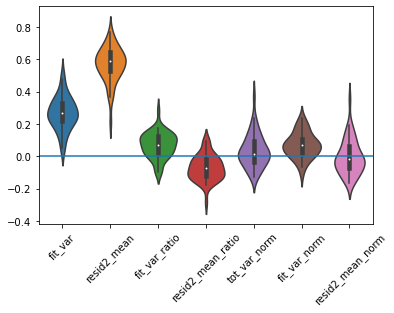

In [14]:
# ax=all_corr_res_all_selected.astype(float).plot(kind='violin')
ax=sns.violinplot(data=all_corr_res_all_selected)
ax.axhline(0)
xticklabels=ax.get_xticklabels()
ax.set_xticklabels(xticklabels,rotation=45)

[Text(0, 0, 'fit_var'),
 Text(1, 0, 'resid2_mean'),
 Text(2, 0, 'fit_var_ratio'),
 Text(3, 0, 'resid2_mean_ratio'),
 Text(4, 0, 'tot_var_norm'),
 Text(5, 0, 'fit_var_norm'),
 Text(6, 0, 'resid2_mean_norm')]

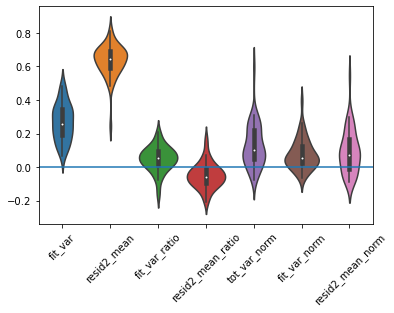

In [117]:
# ax=all_corr_res_all_selected.astype(float).plot(kind='violin')
ax=sns.violinplot(data=all_corr_res_all_selected)
ax.axhline(0)
xticklabels=ax.get_xticklabels()
ax.set_xticklabels(xticklabels,rotation=45)

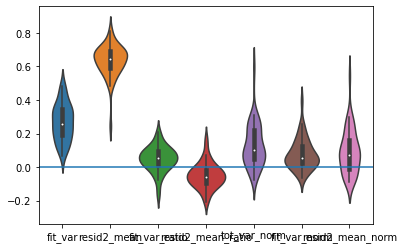

In [66]:
k

('e16_3m2', 'e16_3m2_211213', 1)

In [51]:
res=sacm.decompose_variability_onetrialtype(X_pwc,X_raw)

In [55]:
res_all=sacm.decompose_variability_onetrialtype(X_pwc_all,X_raw_all)

In [56]:
corr_res_all=sacm.post_decomp_corr(res_all)

In [75]:
corr_res['p_corr']

,mean,fit_var_norm,resid2_mean_norm
mean,1.000000,0.044894,0.084729
fit_var_norm,0.044894,1.000000,-0.265263
resid2_mean_norm,0.084729,-0.265263,1.000000


In [54]:
corr_res=sacm.post_decomp_corr(res)
corr_res['p_corr']

,mean,fit_var_norm,resid2_mean_norm
mean,1.000000,0.141178,0.263087
fit_var_norm,0.141178,1.000000,-0.242362
resid2_mean_norm,0.263087,-0.242362,1.000000


In [52]:
res

tot_var       mean   fit_var  resid2_mean  fit_var_ratio  \
0 0.0  2  1  18.921106   7.223817  0.000000    18.921106       0.000000   
          2   5.278644   5.647040  4.541906     0.736738       0.860430   
          3  16.775304  11.598428  0.000000    16.775304       0.000000   
       3  1  33.790127  10.213737  0.000000    33.790127       0.000000   
       4  0   9.541143   4.768913  5.684429     3.856713       0.595781   
...                ...        ...       ...          ...            ...   
  both 30 0  13.526576   8.682727  0.000000    13.526576       0.000000   
       32 0  35.811976  11.835044  0.000000    35.811976       0.000000   
       38 0  42.932386   9.374712  0.000000    42.932386       0.000000   
       47 0  14.870425   6.453665  0.000000    14.870425       0.000000   
       53 0   7.496653   3.517027  0.000000     7.496653       0.000000   

             resid2_mean_ratio  tot_var_norm  fit_var_norm  resid2_mean_norm  
0 0.0  2  1           1.000000      2.619267      0.000000          2.619267  
          2           0.139570      0.934763      0.804298          0.130464  
          3           1.000000      1.446343      0.000000          1.446343  
       3  1           1.000000      3.308302      0.000000          3.308302  
       4  0           0.404219      2.000695      1.191976          0.808720  
...                        ...           ...           ...               ...  
  both 30 0           1.000000      1.557872      0.000000          1.557872  
       32 0           1.000000      3.025927      0.000000          3.025927  
       38 0           1.000000      4.579595      0.000000          4.579595  
       47 0           1.000000      2.304183      0.000000          2.304183  
       53 0           1.000000      2.131531      0.000000          2.131531  

[110 rows x 9 columns]

In [47]:
pval_all

1                \
                                       pval exp_var_ratio   
e13_26m1 e13_26m1_210913 0 0.0  3  0  0.000      0.491237   
                                27 0  0.166      0.165814   
                                29 0  0.001      0.453326   
                                   1  0.825      0.064473   
                                   2  0.409      0.119383   
...                                     ...           ...   
e14_2m3  e14_2m3_201118  0 both 30 0  0.403      0.151445   
                                32 0  0.119      0.245326   
                                38 0  0.379      0.158722   
                                47 0  0.766      0.080927   
                                53 0  0.326      0.164256   

                                                           \
                                     exp_var_ratio_sh_med   
e13_26m1 e13_26m1_210913 0 0.0  3  0             0.101805   
                                27 0             0.101087   
                                29 0             0.101897   
                                   1             0.105516   
                                   2             0.104161   
...                                                   ...   
e14_2m3  e14_2m3_201118  0 both 30 0             0.127051   
                                32 0             0.130907   
                                38 0             0.132976   
                                47 0             0.115922   
                                53 0             0.132305   

                                                            \
                                     exp_var_ratio_sh_high   
e13_26m1 e13_26m1_210913 0 0.0  3  0              0.264699   
                                27 0              0.257435   
                                29 0              0.284425   
                                   1              0.279059   
                                   2              0.267584   
...                                                    ...   
e14_2m3  e14_2m3_201118  0 both 30 0              0.415475   
                                32 0              0.356986   
                                38 0              0.376094   
                                47 0              0.392457   
                                53 0              0.428259   

                                                               2  \
                                     exp_var_ratio_sh_low   pval   
e13_26m1 e13_26m1_210913 0 0.0  3  0             0.034711  0.000   
                                27 0             0.034962  0.038   
                                29 0             0.032056  0.002   
                                   1             0.035038  0.274   
                                   2             0.034143  0.414   
...                                                   ...    ...   
e14_2m3  e14_2m3_201118  0 both 30 0             0.040073  0.240   
                                32 0             0.036339  0.162   
                                38 0             0.038677  0.049   
                                47 0             0.039409  0.936   
                                53 0             0.043596  0.445   

                                                                         \
                                     exp_var_ratio exp_var_ratio_sh_med   
e13_26m1 e13_26m1_210913 0 0.0  3  0      0.666582             0.220174   
                                27 0      0.375642             0.229612   
                                29 0      0.547502             0.224519   
                                   1      0.267998             0.226321   
                                   2      0.242743             0.228880   
...                                            ...                  ...   
e14_2m3  e14_2m3_201118  0 both 30 0      0.389569             0.284919   
                                32 0      0.369193             0.263394   
            

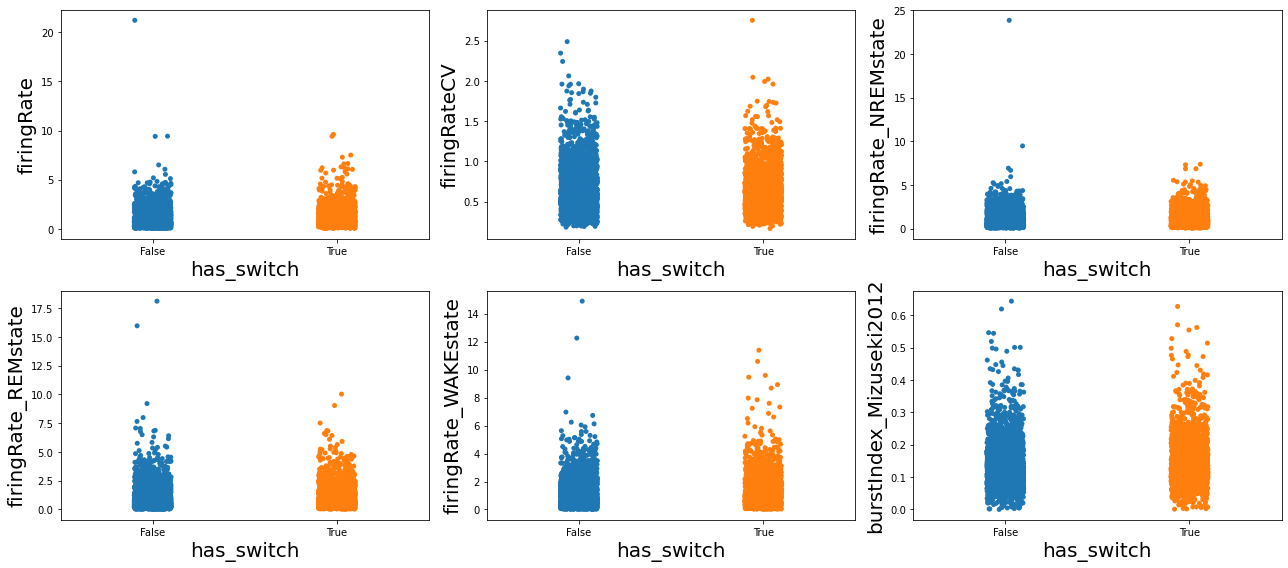

In [123]:
nplots = len(metrics)-2
fig,axs=ph.subplots_wrapper(nplots)
metrics_sub=[m for m in metrics if m not in ['UID','putativeCellType']]
for ii,m in enumerate(metrics_sub):
    ax=axs.ravel()[ii]
    ax=sns.stripplot(ax=ax,x='has_switch',y=m,data=cell_metrics_df_all_pc)
plt.tight_layout()

In [30]:
ani,sess = 'e13_26m1','e13_26m1_210913'
cell_metrics_df_all.loc[ani,sess].loc[31]

/tmp/ipykernel_1061549/1768633858.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_metrics_df_all.loc[ani,sess].loc[31]


putativeCellType           Pyramidal Cell
firingRate                       2.276269
firingRateCV                     0.873728
firingRate_NREMstate             2.357023
firingRate_REMstate              0.898305
firingRate_WAKEstate             2.234699
burstIndex_Mizuseki2012          0.313593
has_switch                           True
Name: 31, dtype: object